In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import glob

In [2]:
def read_restraints_file(file_name):
    retsraint_tags = []
    functional_parameters = ["aC1'C2'C3'", "aC2'C3'C4'", "aC3'C4'O4'", "aC1'O4'C4'", 
                             "dC1'N1", "dC1'N9", "dC1'O4'",
                             "aN1C1'C2'", "aN9C1'C2'", "aC1'N1C2", "aC1'N9C4", "aC1'N1C6", "aC1'N9C8", 
                             "aN1C1'O4'", "aN9C1'O4'"]
    
    with open(file_name) as restraints_file:        
        for line in restraints_file:
            if line.startswith("  # Restraint"):
                retsraint_tags.append(line[14:].strip().split(" "))
                
            if line.startswith("    atom_selection"):
                atom_def = line.strip().split(" ")
                chain = atom_def[3]
                resid = atom_def[6]
                atom = atom_def[9]
                if len(atom_def) > 12:
                    altloc = atom_def[12]
                else:
                    altloc = "0"
                atom_id = "{0}_{1}_{2}_{3}".format(chain, resid, atom, altloc)
                retsraint_tags[-1].append(atom_id)
                
    df = pd.DataFrame(retsraint_tags, columns = ['Name', 'Type', 'Parameter', 'Value', 'Sigma', "Atom1", "Atom2", "Atom3"])
    df.loc[:, "Functional"] = False
    df.loc[df.Parameter.isin(functional_parameters), "Functional"] = True
    df.loc[:, "Value"] = df.loc[:, "Value"].astype(float)
    df.loc[:, "Sigma"] = df.loc[:, "Sigma"].astype(float)
    df.loc[:, "Category"] = "Sugar"
    df.loc[df.Name.str.contains("Base=="), "Category"] = "Base"
    df.loc[df.Name.str.contains("PO4=="), "Category"] = "Phosphate"
    
    df = df.drop_duplicates(["Atom1", "Atom2", "Atom3"], keep='last')
    
    return df

In [40]:
def analyze_restraint_history(restraint_folder="data"):
    refine_nums = sorted([int(f.split("_")[1]) for f in glob.glob(restraint_folder + "/*.txt")])
    name = "data/refine_{0}_restraints.txt"
    rows = []

    for i in range(len(refine_nums) - 1):
        df1 = read_restraints_file(name.format(refine_nums[i]))
        df2 = read_restraints_file(name.format(refine_nums[i+1]))
        
        added_conformations = df1.shape[0] != df2.shape[0]

        df = pd.merge(df1, df2, how='left', on=['Atom1', 'Atom2', 'Atom3'])
        df = df.loc[df.Category_x == "Sugar", :]
        
        df_functional = df.loc[df.Functional_x, :]
        df_groups = df.loc[~df.Functional_x, :]
        df_angles = df.loc[df.Type_x == "angle", :]
        df_dists = df.loc[df.Type_x == "dist", :]

        df_diff = df.loc[df.Value_x != df.Value_y, :]
        df_functional_diff = df_functional.loc[df_functional.Value_x != df_functional.Value_y, :]
        df_groups_diff = df_groups.loc[df_groups.Value_x != df_groups.Value_y, :] 
        functional_changed_pct = df_functional_diff.shape[0] / float(df_functional.shape[0]) * 100
        groups_changed_pct = df_groups_diff.shape[0] / float(df_groups.shape[0]) * 100
        changed_pct = df_diff.shape[0] / float(df.shape[0]) * 100

        mean_angle_change = (df_angles.Value_x - df_angles.Value_y).abs().mean()
        mean_dist_change = (df_dists.Value_x - df_dists.Value_y).abs().mean()

        rows.append([i+1, added_conformations, changed_pct, groups_changed_pct, functional_changed_pct, mean_angle_change, mean_dist_change])

    df = pd.DataFrame(rows, columns = ['Refinement iteration', 'New conformations', 'All restraints', 'Restraint groups', 'Functional restraints', u'Mean angle restraint change [°]', u'Mean distance restraint change [Å]'])
    return df


In [51]:
def create_line_plot(refinement_df, y_col, y_lim, color=None, hue=None, palette=None):
    ax = sns.lineplot(x="Refinement iteration", y=y_col, data=refinement_df, color=color, hue=hue, palette=palette)

    for i in range(refinement_df.shape[0]):
        if refinement_df.iloc[i, 1]:
            ax.axvline(refinement_df.iloc[i, 0]+1, color='#777777', linestyle="--")

    ax.set(ylim=(y_lim))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    return ax
            
def create_analysis_plots():
    df = analyze_restraint_history()
    
    df_changes = df.loc[:, ['Refinement iteration', 'New conformations', 'All restraints', 'Restraint groups', 'Functional restraints']]
    plot_df = df_changes.melt(id_vars=['Refinement iteration', 'New conformations'], var_name="Restraint category", value_name="Restraints changed [%]")
    ax = create_line_plot(plot_df, 'Restraints changed [%]', (0, 100), hue="Restraint category", palette=["#009988", "#0077BB", "#CC3311"])
    plt.show();
    
    for y in [(u'Mean angle restraint change [°]', (0, 0.2), "#EE7733"), (u'Mean distance restraint change [Å]', (0, 0.001), "#EE7733")]:
        ax = create_line_plot(df, y[0], y[1], y[2])
        plt.show();
        ax.figure.savefig(y[0]+".svg")

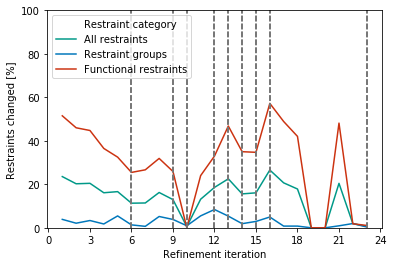

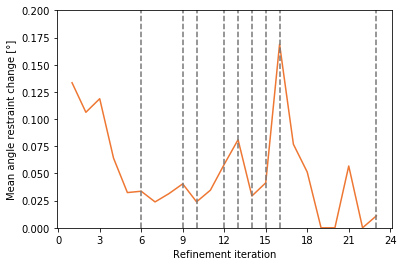

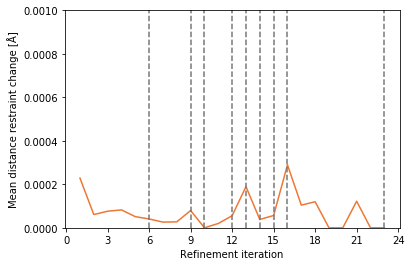

In [52]:
create_analysis_plots()